<a href="https://colab.research.google.com/github/tram-tr/predicting-molecular-properties/blob/main/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# need authorization code to mount drive
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle

Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle


In [3]:
!pip install kaggle
!kaggle competitions download -c champs-scalar-coupling

 99% 374M/377M [00:05<00:00, 43.7MB/s]
100% 377M/377M [00:05<00:00, 74.7MB/s]


In [9]:
!unzip /content/champs-scalar-coupling.zip

Streaming output truncated to the last 5000 lines.
  inflating: structures/dsgdb9nsd_128302.xyz  
  inflating: structures/dsgdb9nsd_128303.xyz  
  inflating: structures/dsgdb9nsd_128304.xyz  
  inflating: structures/dsgdb9nsd_128305.xyz  
  inflating: structures/dsgdb9nsd_128306.xyz  
  inflating: structures/dsgdb9nsd_128308.xyz  
  inflating: structures/dsgdb9nsd_128309.xyz  
  inflating: structures/dsgdb9nsd_128310.xyz  
  inflating: structures/dsgdb9nsd_128311.xyz  
  inflating: structures/dsgdb9nsd_128312.xyz  
  inflating: structures/dsgdb9nsd_128313.xyz  
  inflating: structures/dsgdb9nsd_128314.xyz  
  inflating: structures/dsgdb9nsd_128315.xyz  
  inflating: structures/dsgdb9nsd_128316.xyz  
  inflating: structures/dsgdb9nsd_128317.xyz  
  inflating: structures/dsgdb9nsd_128318.xyz  
  inflating: structures/dsgdb9nsd_128319.xyz  
  inflating: structures/dsgdb9nsd_128320.xyz  
  inflating: structures/dsgdb9nsd_128321.xyz  
  inflating: structures/dsgdb9nsd_128322.xyz  
  inflati

In [4]:
!pip install ase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import math
from numpy.linalg import svd
import ase
from ase import Atoms
import ase.visualize
import warnings
warnings.filterwarnings('ignore')

In [31]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [56]:
train = pd.read_csv('train.csv', nrows=500_000)
structures = pd.read_csv('structures.csv')
contributions = pd.read_csv('scalar_coupling_contributions.csv')

In [58]:
def visualize(molecule_name):
  # select a molecule
  molecule = structures[structures['molecule_name'] == molecule_name]

  # get atomic coordinates
  xcart = molecule.iloc[:, 3:].values

  # get atomic symbols
  symbols = molecule.iloc[:, 2].values

  # display molecule
  system = Atoms(positions=xcart, symbols=symbols)

  print('Molecule Name: %s.' %molecule_name)

  return ase.visualize.view(system, viewer="x3d")

In [60]:
train.head(20)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.80760
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.25700
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25480
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25430
4,4,dsgdb9nsd_000001,2,0,1JHC,84.80740
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.25410
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.25480
7,7,dsgdb9nsd_000001,3,0,1JHC,84.80930
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.25430
9,9,dsgdb9nsd_000001,4,0,1JHC,84.80950


In [61]:
structures.head(10)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602


In [62]:
contributions.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


In [63]:
train = pd.merge(train, contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [64]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,83.0224,0.254579,1.25862,0.272010
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,-11.0347,0.352978,2.85839,-3.433600
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,-11.0325,0.352944,2.85852,-3.433870
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,-11.0319,0.352934,2.85855,-3.433930
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,83.0222,0.254585,1.25861,0.272013


In [65]:
molecule_names = np.unique(train.molecule_name.values.flatten())
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71}
fudge_factor = 0.05
atomic_radius_fudge = {k:v + fudge_factor for k,v in atomic_radius.items()}
electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}
max_atoms = 28

In [66]:
atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]
structures['e_neg'] = atoms_en
structures['rad'] = atoms_rad

  0%|          | 0/2358875 [00:00<?, ?it/s]

  0%|          | 0/2358875 [00:00<?, ?it/s]

In [67]:
structures.head(10)

,molecule_name,atom_index,atom,x,y,z,e_neg,rad
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.77
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.38
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.38
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.38
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.38
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564,3.04,0.75
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,2.20,0.38
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,2.20,0.38
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,2.20,0.38
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,3.44,0.73


In [68]:
atom_idx = structures['atom_index'].values
coords = structures[['x', 'y', 'z']].values
molecules = structures['molecule_name'].values
rads = structures['rad'].values
n_rows = np.arange(len(structures))

# calculate bond distances
bonds = np.zeros((len(structures) + 1, max_atoms + 1), dtype=np.int8)
bond_dists = np.zeros((len(structures) + 1, max_atoms + 1), dtype=np.float32)

coords_temp = coords
molecules_temp = molecules
rads_temp = rads

for i in tqdm(range(max_atoms - 1)):
  coords_temp = np.roll(coords_temp, -1, axis=0)
  molecules_temp = np.roll(molecules_temp, -1, axis=0)
  rads_temp = np.roll(rads_temp, -1, axis=0)

  mask = np.where(molecules==molecules_temp, 1, 0)
  dists = np.linalg.norm(coords - coords_temp, axis=1) * mask
  rad_bond = rads + rads_temp

  bond = np.where(np.logical_and(dists > 0.0001, dists < rad_bond), 1, 0)

  source_row = n_rows
  target_row = source_row + i + 1
  target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row)

  source_atom = atom_idx
  target_atom = atom_idx + i + 1
  target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom)

  bonds[(source_row, target_atom)] = bond
  bonds[(target_row, source_atom)] = bond
  bond_dists[(source_row, target_atom)] = dists
  bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) # remove dummy row
bonds = np.delete(bonds, axis=1, obj=-1) # remove dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) # remove dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) # remove dummy col

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2358875 [00:00<?, ?it/s]

  0%|          | 0/2358875 [00:00<?, ?it/s]

In [69]:
bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)

In [70]:
structures.head(10)

,molecule_name,atom_index,atom,x,y,z,e_neg,rad,n_bonds,bond_lengths_mean
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.77,4,1.091950
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.38,1,1.091953
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.38,1,1.091952
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.38,1,1.091946
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.38,1,1.091948
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564,3.04,0.75,3,1.017195
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,2.20,0.38,1,1.017190
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,2.20,0.38,1,1.017187
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,2.20,0.38,1,1.017208
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,3.44,0.73,2,0.962107


In [71]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])

    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

In [72]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,...,bond_lengths_mean_x,atom_index_y,atom_1,x_1,y_1,z_1,e_neg_y,rad_y,n_bonds_y,bond_lengths_mean_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,83.0224,0.254579,1.25862,0.272010,...,1.091953,0,C,-0.012698,1.085804,0.008001,2.55,0.77,4,1.091950
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,-11.0347,0.352978,2.85839,-3.433600,...,1.091953,2,H,1.011731,1.463751,0.000277,2.20,0.38,1,1.091952
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,-11.0325,0.352944,2.85852,-3.433870,...,1.091953,3,H,-0.540815,1.447527,-0.876644,2.20,0.38,1,1.091946
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,-11.0319,0.352934,2.85855,-3.433930,...,1.091953,4,H,-0.523814,1.437933,0.906397,2.20,0.38,1,1.091948
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,83.0222,0.254585,1.25861,0.272013,...,1.091952,0,C,-0.012698,1.085804,0.008001,2.55,0.77,4,1.091950
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,-11.0317,0.352932,2.85856,-3.433950,...,1.091952,3,H,-0.540815,1.447527,-0.876644,2.20,0.38,1,1.091946
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,-11.0324,0.352943,2.85853,-3.433870,...,1.091952,4,H,-0.523814,1.437933,0.906397,2.20,0.38,1,1.091948
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,83.0241,0.254634,1.25856,0.272012,...,1.091946,0,C,-0.012698,1.085804,0.008001,2.55,0.77,4,1.091950
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543,-11.0319,0.352943,2.85856,-3.433930,...,1.091946,4,H,-0.523814,1.437933,0.906397,2.20,0.38,1,1.091948
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,83.0243,0.254628,1.25856,0.272012,...,1.091948,0,C,-0.012698,1.085804,0.008001,2.55,0.77,4,1.091950


In [76]:
def distance_features(df):
    df['dist'] = np.linalg.norm(df[['x_0', 'y_0', 'z_0']].values - df[['x_1', 'y_1', 'z_1']].values, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    df['type_0'] = df['type'].apply(lambda x: x[0])

    # count number of interactions per molecule
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')

    # mean distance of interactions per molecule
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')

    # minimum interaction distance per molecule
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')

    # maximum interaction distance per molecule
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')

    # count interactions for atom_index_0 within a molecule
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')

    # count interactions for atom_index_1 within a molecule
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')

    # standard deviation of x_1 coordinate for atom_index_0 within a molecule
    df['molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')

    # mean of y_1 coordinate for atom_index_0 within a molecule
    df['molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')

    # difference between atom y_1 coordinate and its mean within a molecule for atom_index_0
    df['molecule_atom_index_0_y_1_mean_diff'] = df['molecule_atom_index_0_y_1_mean'] - df['y_1']

    # division of atom y_1 coordinate by its mean within a molecule for atom_index_0
    df['molecule_atom_index_0_y_1_mean_div'] = df['molecule_atom_index_0_y_1_mean'] / df['y_1']

    # max of y_1 coordinate for atom_index_0 within a molecule
    df['molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')

    # difference between atom y_1 coordinate and its max within a molecule for atom_index_0
    df['molecule_atom_index_0_y_1_max_diff'] = df['molecule_atom_index_0_y_1_max'] - df['y_1']

    # standard deviation of y_1 coordinate for atom_index_0 within a molecule
    df['molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')

    # standard deviation of z_1 coordinate for atom_index_0 within a molecule
    df['molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')

    # mean interaction distance for atom_index_0 within a molecule
    df['molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')

    # difference between interaction distance and its mean for atom_index_0 within a molecule
    df['molecule_atom_index_0_dist_mean_diff'] = df['molecule_atom_index_0_dist_mean'] - df['dist']

    # division of interaction distance by its mean for atom_index_0 within a molecule
    df['molecule_atom_index_0_dist_mean_div'] = df['molecule_atom_index_0_dist_mean'] / df['dist']

    # max interaction distance for atom_index_0 within a molecule
    df['molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')

    # difference between interaction distance and its max for atom_index_0 within a molecule
    df['molecule_atom_index_0_dist_max_diff'] = df['molecule_atom_index_0_dist_max'] - df['dist']

    # division of interaction distance by its max for atom_index_0 within a molecule
    df['molecule_atom_index_0_dist_max_div'] = df['molecule_atom_index_0_dist_max'] / df['dist']

    # minimum interaction distance for atom_index_0 within a molecule
    df['molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform

    df = reduce_mem_usage(df)
    return df

In [77]:
train = distance_features(train)
train.head(10)

Mem. usage decreased to 70.10 Mb (66.6% reduction)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,...,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,83.00000,0.254639,1.258789,0.271973,...,0.377930,0.182251,0.728027,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,<bound method SeriesGroupBy.transform of <pand...
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,-11.03125,0.353027,2.857422,-3.433594,...,0.000000,0.182251,0.728027,1.610352,-0.172729,0.903320,1.783203,0.000037,1.000000,<bound method SeriesGroupBy.transform of <pand...
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,0.016220,0.182251,0.728027,1.610352,-0.172852,0.903320,1.783203,0.000009,1.000000,<bound method SeriesGroupBy.transform of <pand...
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,0.025818,0.182251,0.728027,1.610352,-0.172852,0.903320,1.783203,0.000000,1.000000,<bound method SeriesGroupBy.transform of <pand...
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,83.00000,0.254639,1.258789,0.271973,...,0.361816,0.206177,0.891602,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,<bound method SeriesGroupBy.transform of <pand...
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,0.000000,0.206177,0.891602,1.552734,-0.230347,0.870605,1.783203,0.000000,1.000000,<bound method SeriesGroupBy.transform of <pand...
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,0.009598,0.206177,0.891602,1.552734,-0.230347,0.870605,1.783203,0.000009,1.000000,<bound method SeriesGroupBy.transform of <pand...
7,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,83.00000,0.254639,1.258789,0.271973,...,0.352051,0.249023,0.635254,1.437500,0.345703,1.316406,1.783203,0.691406,1.632812,<bound method SeriesGroupBy.transform of <pand...
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,0.000000,0.249023,0.635254,1.437500,-0.345703,0.806152,1.783203,0.000000,1.000000,<bound method SeriesGroupBy.transform of <pand...
9,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,83.00000,0.254639,1.258789,0.271973,...,0.000000,NaN,NaN,1.091797,0.000000,1.000000,1.091797,0.000000,1.000000,<bound method SeriesGroupBy.transform of <pand...


In [79]:
# PCA + SVD
# get the principal eigenvector of molecule axis
def PCA_SVD(a):
  a_mean = a.mean(axis=1)
  #normalise
  a = (a.T - a_mean.T).T
  u, s, v = svd(a.T)
  return(v[0])

# get the plane with minimum sum distance from the nuclei
def get_plane(a):
  a = np.reshape(a, (a.shape[0], -1))
  centroid = a.mean(axis=1)
  #normalise
  x = a - centroid[:,np.newaxis]
  m = np.dot(x, x.T)
  return(centroid, svd(m)[0][:,-1])

In [80]:
size_list = []
flatness = []
bond_angle_plane = []
bond_angle_axis = []
diheral_angle = []

for i in tqdm(range(len(molecule_names))):
  molecule = molecule_names[i]

  # get structure and bond information for each molecule
  struct = structures.loc[structures.molecule_name==molecule, :]
  bonds = train.loc[train.molecule_name==molecule, :]

  # number of constituent atoms
  size = len(struct)
  size_list.extend(np.full(len(bonds), size))

  # nuclei coordinates
  coords = np.column_stack([struct.x.values, struct.y.values, struct.z.values]).T

  # principal axis of molecular alignment
  axis_vector = PCA_SVD(coords)

  # get flatness metric and plane angles for binds if nuclei > 3
  if size > 3:
    coords = coords - coords.mean()
    # get best fitting 2D plane
    ctr, norm = get_plane(coords)

    # calculate distances of each atom from plane
    dists = np.zeros(size)
    for j in range(size):
      dists[j] = np.dot(norm, coords[:, j] - ctr)

    dist = abs(dists).sum()/len(dists)
    flatness.extend(np.full(len(bonds), dist))

    # get angle subtented by each atomic bind and plane
    for j in range(len(bonds)):
        # get atom index numbers for this bond
        atom1 = bonds.atom_index_0.values[j]
        atom2 = bonds.atom_index_1.values[j]

        # get 3D coords
        atom1_coords = coords[:, atom1]
        atom2_coords = coords[:, atom2]

        # bond vector
        atom_vec = np.array([atom1_coords[0] - atom2_coords[0],
                              atom1_coords[1] - atom2_coords[1],
                              atom1_coords[2] - atom2_coords[2]])

        # get bond angles
        angle = np.dot(norm, atom_vec)/(np.linalg.norm(norm)*np.linalg.norm(atom_vec))
        axis_angle = np.dot(axis_vector, atom_vec)/(np.linalg.norm(norm)*np.linalg.norm(atom_vec))

        angle = math.degrees(np.arccos(angle))
        axis_angle = math.degrees(np.arccos(axis_angle))

        if angle > 90:
            angle = 180 - angle

        if axis_angle > 90:
            axis_angle = 180 - axis_angle

        angle = 90 - angle
        axis_angle = 90 - axis_angle
        bond_angle_plane.append(angle)
        bond_angle_axis.append(axis_angle)

  else:
    flatness.extend(np.full(len(bonds), np.nan))
    bond_angle_plane.extend(np.full(len(bonds), np.nan))

    for j in range(len(bonds)):
      # get atom index numbers for this bond
      atom1 = bonds.atom_index_0.values[j]
      atom2 = bonds.atom_index_1.values[j]

      # get 3D coords
      atom1_coords = coords[:, atom1]
      atom2_coords = coords[:, atom2]

      # bond vector
      atom_vec = np.array([atom1_coords[0] - atom2_coords[0],
                            atom1_coords[1] - atom2_coords[1],
                            atom1_coords[2] - atom2_coords[2]])

      # get bond angles
      axis_angle = np.dot(axis_vector, atom_vec)/(np.linalg.norm(axis_vector)*np.linalg.norm(atom_vec))

      # standardise to degrees <= 90
      axis_angle = math.degrees(np.arccos(axis_angle))

      if axis_angle > 90:
          axis_angle = 180 - axis_angle

      axis_angle = 90 - axis_angle
      bond_angle_axis.append(axis_angle)


  0%|          | 0/10398 [00:00<?, ?it/s]

In [81]:
train['num_atoms'] = np.asarray(size_list)
train['flatness'] = np.asarray(flatness)
train['bond_angle_plane'] = np.asarray(bond_angle_plane)
train['bond_angle_axis'] = np.asarray(bond_angle_axis)

In [83]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,...,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,num_atoms,flatness,bond_angle_plane,bond_angle_axis
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,83.00000,0.254639,1.258789,0.271973,...,0.518555,1.474609,1.783203,0.691406,1.632812,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,52.084398,34.460611
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,-11.03125,0.353027,2.857422,-3.433594,...,-0.172729,0.903320,1.783203,0.000037,1.000000,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,73.351062,0.804265
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,-0.172852,0.903320,1.783203,0.000009,1.000000,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,39.073948,44.696355
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,-0.172852,0.903320,1.783203,0.000000,1.000000,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,20.124219,44.160617
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,83.00000,0.254639,1.258789,0.271973,...,0.460693,1.421875,1.783203,0.691406,1.632812,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,50.858665,36.069177
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,-0.230347,0.870605,1.783203,0.000000,1.000000,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,19.131573,45.838738
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,-0.230347,0.870605,1.783203,0.000009,1.000000,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,37.879628,45.292858
7,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,83.00000,0.254639,1.258789,0.271973,...,0.345703,1.316406,1.783203,0.691406,1.632812,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,13.909861,35.642512
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.257812,-11.03125,0.353027,2.859375,-3.433594,...,-0.345703,0.806152,1.783203,0.000000,1.000000,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,16.634444,0.382380
9,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,83.00000,0.254639,1.258789,0.271973,...,0.000000,1.000000,1.091797,0.000000,1.000000,<bound method SeriesGroupBy.transform of <pand...,5,0.443764,13.124885,34.877747


In [86]:
# cutoff function
def fc(Rij, Rc):
    y_1 = 0.5*(np.cos(np.pi*Rij[Rij<=Rc]/Rc)+1)
    y_2 = Rij[Rij>Rc]*0
    y = np.concatenate((y_1,y_2))
    return y

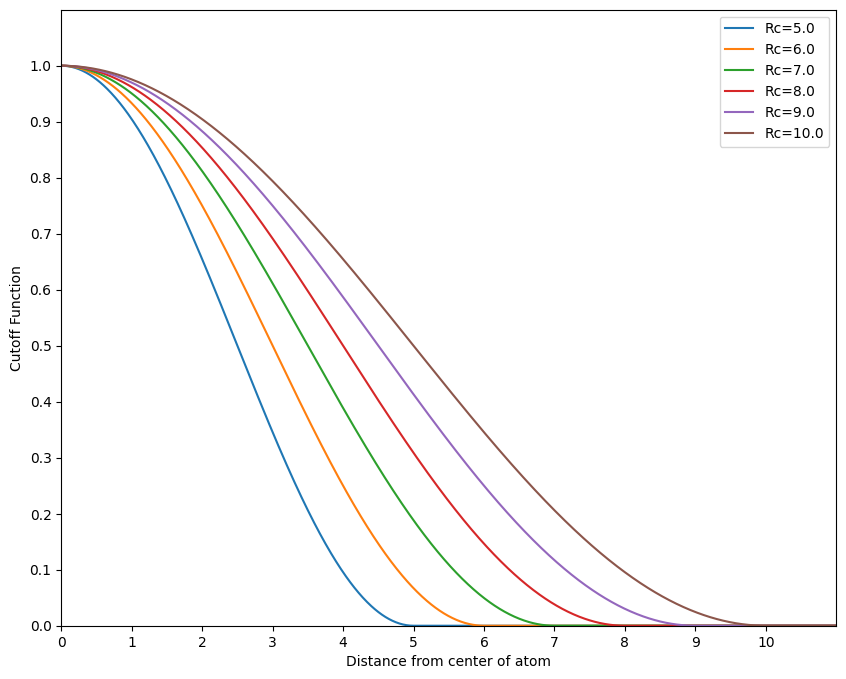

In [87]:
x = np.arange(0, 11, 0.01)

# plot the function with different cutoff radii
Rc_range = [5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

fig = plt.figure(figsize=(10,8))

for Rc in Rc_range:
    plt.plot(x, fc(x,Rc), label=f'Rc={Rc}')

plt.axis([0, 11, 0, 1.1])
plt.xticks(range(11))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Distance from center of atom')
plt.ylabel('Cutoff Function')
plt.legend()

plt.show()